In [1]:
import pandas as pd
import nltk
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

In [2]:
recipes = pd.read_csv('secret/csv_for_mySQL/recipe_with_discr.csv')

In [26]:
recipes.columns

Index(['name', 'id', 'minutes', 'submitted', 'n_steps', 'steps', 'description',
       'ingredients', 'n_ingredients', 'calories', 'total fat', 'sugar',
       'sodium', 'protein', 'saturated fat', 'carbohydrates', 'food_types',
       'rating'],
      dtype='object')

In [39]:
recipes.isna().sum()

name                0
id                  0
minutes             0
submitted           0
n_steps             0
steps               0
description      4978
ingredients         0
n_ingredients       0
calories            0
total fat           0
sugar               0
sodium              0
protein             0
saturated fat       0
carbohydrates       0
food_types          0
rating              0
dtype: int64

In [3]:
recipes_dropped = recipes[recipes['description'].notna()]


In [4]:
recipes_dropped.isna().sum()

name             0
id               0
minutes          0
submitted        0
n_steps          0
steps            0
description      0
ingredients      0
n_ingredients    0
calories         0
total fat        0
sugar            0
sodium           0
protein          0
saturated fat    0
carbohydrates    0
food_types       0
rating           0
dtype: int64

In [18]:
recipes_dropped['ingredients'] = recipes_dropped['ingredients'].str.replace(',', ' ')

In [23]:
recipes.head()

,name,id,minutes,submitted,n_steps,steps,description,ingredients,n_ingredients,calories,total fat,sugar,sodium,protein,saturated fat,carbohydrates,food_types,rating
0,arriba baked winter squash mexican style,137739,55,2005-09-16,11,1. make a choice and proceed with recipe 2. de...,autumn is my favorite time of year to cook! th...,winter squash mexican seasoning mixed spice ...,7,51.5,0.0,13.0,0.0,2.0,0.0,4.0,"Gluten-Free, Low-calories",5.0
1,a bit different breakfast pizza,31490,30,2002-06-17,9,1. preheat oven to 425 degrees f 2. press doug...,this recipe calls for the crust to be prebaked...,prepared pizza crust sausage patty eggs mil...,6,173.4,18.0,0.0,17.0,22.0,35.0,1.0,"Gluten-Free, Low-calories",3.5
2,all in the kitchen chili,112140,130,2005-02-25,6,1. brown ground beef in large pot 2. add chopp...,this modified version of 'mom's' chili was a h...,ground beef yellow onions diced tomatoes to...,13,269.8,22.0,32.0,48.0,39.0,27.0,5.0,"Gluten-Free, Low-calories",4.0
3,alouette potatoes,59389,45,2003-04-14,11,1. place potatoes in a large pot of lightly sa...,"this is a super easy, great tasting, make ahea...",spreadable cheese with garlic and herbs new p...,11,368.1,17.0,10.0,2.0,14.0,8.0,20.0,Gluten-Free,4.5
4,amish tomato ketchup for canning,44061,190,2002-10-25,5,1. mix all ingredients& boil for 2 1 2 hours ...,my dh's amish mother raised him on this recipe...,tomato juice apple cider vinegar sugar salt...,8,352.9,1.0,337.0,23.0,3.0,0.0,28.0,Gluten-Free,5.0


In [19]:
word_freq= ''
vocabulary = nltk.FreqDist()
# This was done once I had already preprocessed the ingredients
for ingredients in recipes['ingredients']:
    ingredients = ingredients.split()
    vocabulary.update(ingredients)
for word, frequency in vocabulary.most_common(30):
    word_freq += (word + ' ')
    print(f'{word};{frequency}')


salt,;94345
pepper,;85954
sugar,;80676
fresh;75239
oil,;72059
ground;64643
butter,;64077
cheese,;58555
flour,;55847
onion,;55799
garlic;52466
powder,;48634
olive;41719
sauce,;40746
red;39827
water,;39349
chicken;38725
black;37459
milk,;36952
juice,;35271
baking;34591
eggs,;33683
pepper;32468
green;32392
salt;31333
cloves,;29549
dried;29131
white;28083
lemon;27654
brown;27052


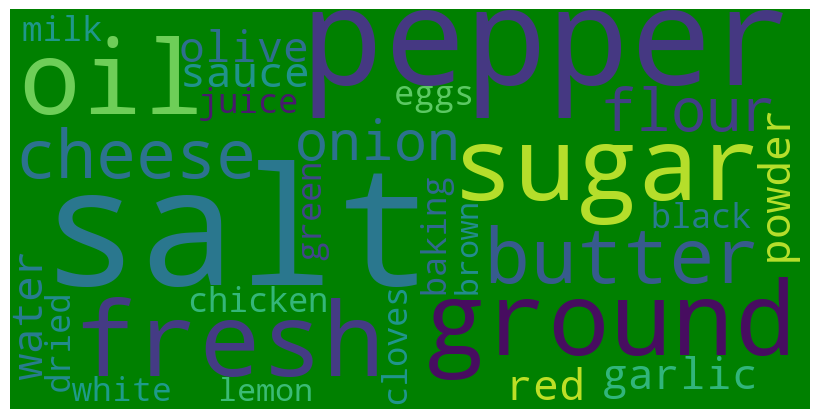

In [22]:
wordcloud = WordCloud(width=800, height=400, background_color='green').generate(word_freq)

plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


## Part I - Cosine similarity

In [20]:
recipes_dropped.columns

Index(['name', 'id', 'minutes', 'submitted', 'n_steps', 'steps', 'description',
       'ingredients', 'n_ingredients', 'calories', 'total fat', 'sugar',
       'sodium', 'protein', 'saturated fat', 'carbohydrates', 'food_types',
       'rating'],
      dtype='object')

In [24]:
# Select the columns of interest
#recipe_df = recipes_dropped[['name', 'description', 'ingredients']]

# Concatenate the columns into a single text column
#recipe_df['text'] = recipe_df['name'] + ' ' + recipe_df['description'] + ' ' + recipe_df['ingredients']
recipes_dropped['text'] = recipes_dropped['name'] + ' '+ recipes_dropped['ingredients'] + ' ' + recipes_dropped['description']

# Replace any NaN values with an empty string
recipes_dropped['text'] = recipes_dropped['text'].fillna('')

In [25]:
import re

# Define a custom tokenizer function to remove stop words
def custom_tokenizer(text):
    # Define a list of stop words
    stop_words = ["a", "all","an", "bit","the", "and", "or", "in", "on", "at", "to", "for", "with", "by", "of", "from", "as", "be", "was", "were"]

    # Split the text into words
    words = re.findall(r'\b\w+\b', text)

    # Remove stop words
    words = ' '.join(word for word in words if word not in stop_words) #join returns a string 
    return words

In [26]:
recipes_dropped['text'] = recipes_dropped['text'].apply(custom_tokenizer)

In [27]:
import random

# Choose a subset of recipes
subset_size = 15000
subset_indices = random.sample(range(len(recipes_dropped)), subset_size)
subset_recipe_df = recipes_dropped.iloc[subset_indices]

In [28]:
# Create a TfidfVectorizer object to transform the text data
vectorizer = TfidfVectorizer(stop_words='english', analyzer='word')

# Transform the text data into a sparse matrix
text_matrix = vectorizer.fit_transform(subset_recipe_df['text'])

In [26]:
text_matrix.shape

(15000, 19453)

In [27]:
# Compute cosine similarity between all pairs of recipes
cosine_sim = cosine_similarity(text_matrix)

#8minutes run and error of memory capacity


In [28]:
len(cosine_sim)

15000

In [29]:
import joblib
joblib.dump(cosine_sim, 'pickles/cosine_sim15k.joblib')

['pickles/cosine_sim15k.joblib']

In [13]:
import pickle

with open('pickles/cosine_sim.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)

to load pickle
with open ('pickles/cosine_sim.pkl', 'rb') as f:
    cosine_sim = pickle.load(f)

In [31]:
import pickle

with open ('pickles/cosine_sim.pkl', 'rb') as f:
    cosine_sim = pickle.load(f)

In [65]:
subset_recipe = pd.read_csv('pickles/recipes_30k_random.csv')

 The resulting cosine_sim matrix will be a square matrix where the value at row i and column j represents the cosine similarity between recipes i and j.

In [55]:
subset_recipe= subset_recipe.reset_index(drop=True)

In [85]:
# Select two recipes to compare
recipe1 = subset_recipe.iloc[9473]
recipe2 = subset_recipe.iloc[8048]

# Compute the cosine similarity between the two recipes
cosine_sim_12 = cosine_sim[9473, 8048]

print(f"The cosine similarity between '{recipe1['name']}' and '{recipe2['name']}' is {cosine_sim_12:.2f}")


The cosine similarity between 'broccoli pork' and 'pork tenderloin with cumberland sauce' is 0.43


If the cosine similarity calculation is working correctly, you should see a value between 0 and 1 that represents the similarity between the two recipes. A value of 1 would mean that the two recipes are identical, while a value of 0 would mean that they have no similarity.

This function takes three arguments: the name of the input recipe, the recipe dataframe recipe_df, and the cosine similarity matrix cosine_sim. It also has an optional parameter n which specifies the number of most similar recipes to return (default is 3).

The function first finds the index of the input recipe in the dataframe. It then retrieves the cosine similarity scores between the input recipe and all other recipes from the cosine_sim matrix. The scores are stored as a list of (recipe index, similarity score) tuples. The list is sorted by the similarity score in descending order, and the top n most similar recipes (excluding the input recipe itself) are selected from the dataframe using the iloc method.

In [31]:
subset_recipe.to_csv('pickles/recipes_15k_random_joblib.csv')
subset_recipe.head()

,name,id,minutes,submitted,n_steps,steps,description,ingredients,n_ingredients,calories,total fat,sugar,sodium,protein,saturated fat,carbohydrates,food_types,rating,text
0,dilled white bean and grape tomato salad,428248,70,2010-06-02,6,1. toss all ingredients in a large bowl 2. sea...,"from the june, 2010 issue of bon appetite. thi...",cannellini beans grape tomatoes red onion f...,10,222.5,15.0,22.0,17.0,16.0,7.0,8.0,"Gluten-Free, Low-calories",4.533333,dilled white bean grape tomato salad cannellin...
1,tuna spook sandwiches halloween lunch box sur...,257172,10,2007-10-05,7,1. drain water from tuna and place in small mi...,cute lunch box idea for halloween that your li...,tuna fish mayonnaise fresh lemon juice cele...,6,199.3,6.0,13.0,20.0,24.0,3.0,9.0,Low-calories,5.000000,tuna spook sandwiches halloween lunch box surp...
2,easy cream cheese dip,17649,5,2002-01-21,3,1. pour about half of the salsa into a blender...,i got this recipe from a family christmas part...,fat free cream cheese salsa,2,44.0,0.0,12.0,20.0,10.0,1.0,1.0,"Gluten-Free, Low-calories",4.500000,easy cream cheese dip fat free cream cheese sa...
3,honey roasted applesauce,256107,40,2007-09-29,13,1. preheat oven to 425 degrees f 2. peel the a...,i saw this on easy entertaining today. super e...,apples sweet butter fresh lemon juice sea s...,5,164.1,6.0,119.0,8.0,0.0,12.0,11.0,"Gluten-Free, Low-calories",5.000000,honey roasted applesauce apples sweet butter f...
4,kansas city barbecue sauce,172027,15,2006-06-08,8,1. in medium saucepan cook onion and garlic in...,realfood4realpeople at yahoo groups.,onion garlic cloves olive oil apple juice ...,13,29.7,1.0,17.0,6.0,0.0,0.0,1.0,"Gluten-Free, Low-calories",4.000000,kansas city barbecue sauce onion garlic cloves...


In [40]:
def get_name_from_index(index):
    return subset_recipe[subset_recipe.index == index]['name'].values[0]

def get_index_from_name(name):
    return subset_recipe[subset_recipe.name == name].index[0]

In [91]:
recipe_to_find = 'broccoli pie'
recipe_index = get_index_from_name(recipe_to_find)
recipe_index

6680

In [83]:
recipe_to_find = 'pork tenderloin with cumberland sauce'
recipe_index = get_index_from_name(recipe_to_find)
recipe_index

8048

In [63]:
get_name_from_index(4088)

'broccoli pork'

In [92]:
similar_rec = list(enumerate(cosine_sim[recipe_index])) #accessing the row corresponding to given recipe to find all the similarity scores for that recipe and then enumerating over it
sorted_similar = sorted(similar_rec,key=lambda x:x[1],reverse=True)[1:]

In [93]:
i = 0
print(f'Top 5 similar recipes to "try" are:\n')
if sorted_similar:
    for element in sorted_similar:
        print(get_name_from_index(element[0]))
        i += 1
        if i > 4:
            break
else:
    print('No similar recipes found.')


Top 5 similar recipes to "try" are:

cream of broccoli cheese soup
broccoli cheese soup
grandma s egg custard pie
broccoli parmesan
nestle toll house pie


In [60]:
def get_similar(subset_recipe= subset_recipe, cosine_sim=cosine_sim):
    recipe_to_find = input("Enter the name of a recipe: ")
    
    try:
        recipe_index = get_index_from_name(recipe_to_find)
    except :
        print(f"Sorry, the {recipe_to_find} recipe you entered could not be found.")
        print('I found some similar recipe names in my library: ')
        n=3
        all_names = subset_recipe['name'].values.tolist()

        # Find the most similar names using fuzzy matching
        similar_names = process.extract(recipe_to_find, all_names, scorer=fuzz.token_sort_ratio, limit=n)

        # Extract the names and similarity scores
        similar_names = [(n, s) for n, s in process.extract(recipe_to_find, all_names, scorer=fuzz.token_sort_ratio, limit=n)]

        print('Similar recipe names:')
        for i, (name, score) in enumerate(similar_names):
            print(f"{i+1}. {name}")
        
        # Ask user to choose a similar recipe name
        choice = input('Enter the number of the recipe you meant to find (or press enter to exit): ')
        if not choice:
            return
        try:
            choice = int(choice)
            recipe_to_find = similar_names[choice-1][0]
            recipe_index = get_index_from_name(recipe_to_find)
        except (ValueError, IndexError):
            print('Invalid choice.')
            return
   
    similar_rec = list(enumerate(cosine_sim[recipe_index]))
    sorted_similar = sorted(similar_rec, key=lambda x: x[1], reverse=True)[1:]
    
    print(f"Top 5 similar recipes to '{recipe_to_find}' are:\n")
    for i, element in enumerate(sorted_similar[:5]):
        print(f"{i+1}. {get_name_from_index(element[0])}")

    # Ask the user to select a recipe
    selected_recipe = input("Enter the number of a recipe to see its steps and ingredients (or 'q' to quit): ")
    if selected_recipe == 'q':
        return
    
    # Convert the selected recipe to an integer and get its index
    try:
        selected_recipe_index = sorted_similar[int(selected_recipe)-1][0]
    except:
        print("Invalid selection.")
        return
    
    # Get the steps and ingredients for the selected recipe
    recipe_name = get_name_from_index(selected_recipe_index)
    recipe_steps = subset_recipe.loc[selected_recipe_index, 'steps']
    recipe_ingredients = subset_recipe.loc[selected_recipe_index, 'ingredients']

    # Print the steps and ingredients
    print(f"\n{recipe_name}\n")
    print(f"Ingredients: {recipe_ingredients}")
    print(f"\nSteps: {recipe_steps}")
    

 Ask the user to select a recipe
    selected_recipe = input("Enter the number of a recipe to see its steps and ingredients (or 'q' to quit): ")
    if selected_recipe == 'q':
        return

    # Convert the selected recipe to an integer and get its index
    try:
        selected_recipe_index = sorted_similar[int(selected_recipe)-1][0]
    except:
        print("Invalid selection.")
        return

    # Get the steps and ingredients for the selected recipe
    recipe_name = get_name_from_index(selected_recipe_index)
    recipe_steps = subset_recipe.loc[selected_recipe_index, 'steps']
    recipe_ingredients = subset_recipe.loc[selected_recipe_index, 'ingredients']

    # Print the steps and ingredients
    print(f"\n{recipe_name}\n")
    print("Ingredients:")
    for ingredient in recipe_ingredients:
        print(f"- {ingredient}")
    print("\nSteps:")
    for i, step in enumerate(recipe_steps):
        print(f"{i+1}. {step}")

In [96]:
top_similar = get_similar(subset_recipe, cosine_sim)
top_similar

Top 5 similar recipes to 'chicken thai curry' are:

1. green coconut curry with vegetables
2. curry chicken  fast   easy
3. thai vegetable curry
4. gaeng keow wan gai   thai green curry chicken
5. thai green chicken curry  diabetic friendly   sugarless

curry chicken  fast   easy

Ingredients: cooking oil, garlic, curry powder, onions, whole chicken, water, salt, potatoes

Steps: 1. in a large pot heat up cooking oil add chopped garlic and onion lightly fry 2. add curry powder and stir together quickly 3. do not burn then add 1  4 cup of the water bringing to a light simmer 4. stir in chicken until its completely covered and all mixed together in the curry and is starting to lightly cook 5. 3-5 minutes 6. add in balance of water and salt and bring to boil 7. turn heat down to med & lightly simmer for 45 minutes covered 8. add in potatoes 9. then continue to simmer until potatoes are done 10. put on a bed of rice or eat this as a stew 11. this simply is the best curry youll ever eat tha

In [89]:
from fuzzywuzzy import fuzz, process

def find_similar_recipe_names(name, subset_recipe, n=3):
    # Get all recipe names in the dataframe
    all_names = subset_recipe['name'].values.tolist()

    # Find the most similar names using fuzzy matching
    similar_names = process.extract(name, all_names, scorer=fuzz.token_sort_ratio, limit=n)

    # Extract the names and similarity scores
    similar_names = [(n, s) for n, s in process.extract(name, all_names, scorer=fuzz.token_sort_ratio, limit=n)]

    return similar_names


In [95]:
findy = find_similar_recipe_names('chicken curry', subset_recipe)
findy

[('chicken thai curry', 84),
 ('curry chicken udon', 84),
 ('easy chicken curry', 84)]

In [96]:
trying = 'cream of broccoli cheese soup'

In [68]:
indices = get_index_from_name(trying)
indices

17812

In [69]:
locking = subset_recipe.loc[[indices], ['description']]
locking

,description
17812,"another one of my no-flame-required, kid-frien..."


In [73]:
desc_text = ' '.join(locking.values.ravel().tolist())

#desc_text = ' '.join(locking.values.astype(str))
desc_text

'another one of my no-flame-required, kid-friendly recipes.  i remember making these in my after school program in grade school and loving them.  they are a great wholesome activity for kids parties...just make sure an adult slices the apples.  my favorite apples to use are pink lady because the tart flavor is a nice compliment to the peanut butter.  for a healthier variation, use cubed slightly green bananas instead of marshmallows...ripe bananas may be mushy.  if you are worried about peanut butter allergies, substitute cashew nut butter as it is far less common to be allergic to.'

In [81]:
from wordcloud import WordCloud, get_single_color_func
import matplotlib.pyplot as plt

def make_a_cloud(top_similar):
    # Convert top_similar to a list of integer indices
    indices = get_index_from_name(top_similar)

    # Concatenate the descriptions of the top n most similar recipes
    locking = subset_recipe.loc[[indices], ['description']]
    desc_text = ' '.join(locking.values.ravel().tolist())
    def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
        h = random.randint(0, 359)
        s = random.randint(60, 100)
        l = random.randint(30, 70)
        return "hsl({}, {}%, {}%)".format(h, s, l)
    # Create a word cloud object with the desired parameters
    wordcloud = WordCloud(width=800, height=400,color_func=random_color_func, background_color='rgba(0,0,0,0)', max_words=100).generate(desc_text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

    # Return the top n most similar recipes
    return top_similar


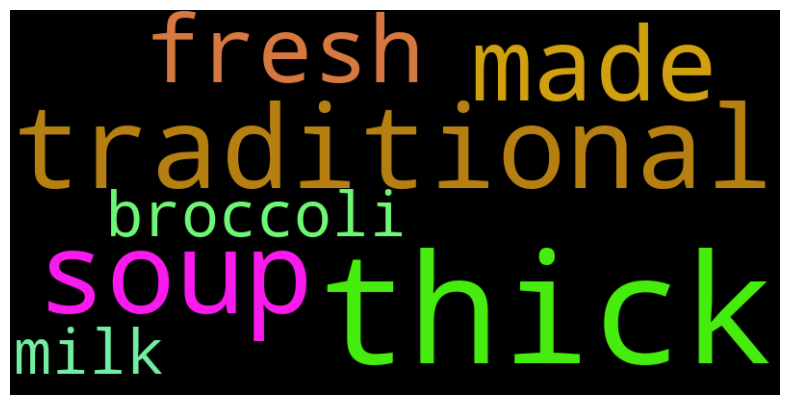

cream of broccoli cheese soup


In [97]:
similar = make_a_cloud(trying)
print(similar)